# Vector Quantized Auto-Encoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import data_loader

batch_size = 128
lr = .001

dim_input = (3, 32, 32)
dim_hidden = 400
dim_latent = 200
beta_commitment = 0.25

train_loader, validation_loader, test_loader = data_loader.load_cifar10(batch_size=batch_size)

torch.cuda.is_available()

100%|██████████| 170498071/170498071 [00:10<00:00, 16789565.68it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


False

torch.Size([3, 32, 32])


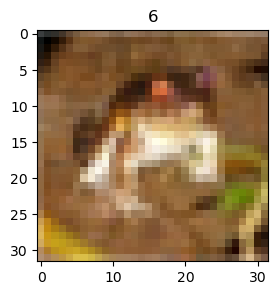

In [7]:
import matplotlib.pyplot as plt

print(train_loader.dataset[4][0].shape)

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0].permute(1, 2, 0))
plt.show()

In [ ]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super(VectorQuantizer, self).__init__()
    
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim) # (K,D)
    # initialize weights of imbedding from uniform distribution
    self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
    
  def forward(self, inputs):
    inputs = inputs.permute(0,2,3,1).contiguous() # (B, H, W, C=D)
    input_shape = inputs.shape
    
    flat_input = inputs.view(-1, self.embedding_dim) # (B*H*W, C=D)
    
    # distance between choice of embeddings and input
    distances = (torch.sum(flat_input**2, dim=1, keepdim=True) # (B*H*W, 1)
                 + torch.sum(self.embedding.weight**2, dim=1) # (B*H*W, 1)
                 - 2 *torch.matmul(flat_input, self.embedding.weight.t())) # (B*H*W, D) x (D x K) = (B*H*W, K)
    # (B*H*W, K)
    
    # set the encoding
    # encoding to index of closest embeddings to input
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # (B*H*W, 1), indicies will be in the range of K
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings) # (B*H*W, K)
    encodings.scatter(1, encoding_indices, 1) # set encoding indices as 1
    
    quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape) # (B*H*W, K) x (K, D) = (B*H*W, D) => (B, H, W, D)
    
    # q_latent_loss + beta * e_latent_loss
    e_latent_loss = functional.mse_loss(quantized.detach(), inputs) # move inputs closer to embeddings
    q_latent_loss = functional.mse_loss(quantized, inputs.detach()) # move embeddings closer to inputs
    loss = q_latent_loss + self.commitment_cost * e_latent_loss
    
    # what is the point of detaching the second term? why not just load the resultant quantized values calculated above?
    quantized = inputs + (quantized - inputs).detach() # (B, H, W, D)
    avg_probs = torch.mean(encodings, dim=0) # (K)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10))) # just something to mesure performance
    
    return loss, quantized.permute(0, 3, 1, 2).continguous(), perplexity, encodings

In [ ]:
class Residual(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
    super(Residual, self).__init__()
    self.block = nn.Sequential(
      nn.ReLU(True),
      nn.Conv2d(in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(True),
      nn.Conv2d(in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1, stride=1, bias=False)
    )

  def forward(self, x):
      return x + self.block(x)